In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import pymysql
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [3]:
# Cargar variables de entorno
load_dotenv(os.path.join('..', '.env'))

# Crear conexión con SQLAlchemy
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

engine = create_engine(f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}')

print(f"✅ Conectado a la base de datos: {db_name}")

✅ Conectado a la base de datos: supply_chain_db


In [4]:
# Cargar todas las tablas
products_df = pd.read_sql("SELECT * FROM products", engine)
suppliers_df = pd.read_sql("SELECT * FROM suppliers", engine)
sales_df = pd.read_sql("SELECT * FROM sales", engine)
logistics_df = pd.read_sql("SELECT * FROM logistics", engine)
production_df = pd.read_sql("SELECT * FROM production", engine)

print("📊 Datos cargados:")
print(f"   Productos: {len(products_df)} registros")
print(f"   Proveedores: {len(suppliers_df)} registros")
print(f"   Ventas: {len(sales_df)} registros")
print(f"   Logística: {len(logistics_df)} registros")
print(f"   Producción: {len(production_df)} registros")

📊 Datos cargados:
   Productos: 100 registros
   Proveedores: 5 registros
   Ventas: 100 registros
   Logística: 100 registros
   Producción: 100 registros


In [6]:
# Unir todas las tablas - seleccionando solo columnas necesarias para evitar duplicados

# Preparar cada dataframe quitando columnas redundantes
products_clean = products_df.drop(columns=['id', 'created_at'])
logistics_clean = logistics_df.drop(columns=['id', 'created_at'])
production_clean = production_df.drop(columns=['id', 'created_at'])
sales_clean = sales_df.drop(columns=['id', 'created_at'])

# Hacer el merge
df_analysis = sales_clean.merge(products_clean, on='sku', how='left') \
                         .merge(logistics_clean, on='sku', how='left') \
                         .merge(production_clean, on='sku', how='left')

print(f"📊 Dataset consolidado: {df_analysis.shape[0]} filas x {df_analysis.shape[1]} columnas")
df_analysis.head()

📊 Dataset consolidado: 100 filas x 19 columnas


,sku,products_sold,revenue_generated,customer_demographics,product_type,price,availability,stock_levels,shipping_times,shipping_carrier,shipping_costs,transportation_mode,route,total_costs,production_volumes,manufacturing_lead_time,manufacturing_costs,inspection_results,defect_rates
0,SKU0,802,8662.00,Non-binary,haircare,69.81,55,58,4,Carrier B,2.96,Road,Route B,187.75,215,29,46.28,Pending,0.23
1,SKU1,736,7460.90,Female,skincare,14.84,95,53,2,Carrier A,9.72,Road,Route B,503.07,517,30,33.62,Pending,4.85
2,SKU2,8,9577.75,Unknown,haircare,11.32,34,1,2,Carrier B,8.05,Air,Route C,141.92,971,27,30.69,Pending,4.58
3,SKU3,83,7766.84,Non-binary,skincare,61.16,68,23,6,Carrier C,1.73,Rail,Route A,254.78,937,18,35.62,Fail,4.75
4,SKU4,871,2686.51,Non-binary,skincare,4.81,26,5,8,Carrier A,3.89,Air,Route A,923.44,414,3,92.07,Fail,3.15


In [7]:
print("=" * 70)
print("📈 KPIS PRINCIPALES DE SUPPLY CHAIN")
print("=" * 70)

# Revenue total
total_revenue = df_analysis['revenue_generated'].sum()
print(f"\n💰 Revenue Total: ${total_revenue:,.2f}")

# Productos más vendidos
total_products_sold = df_analysis['products_sold'].sum()
print(f"📦 Total Productos Vendidos: {total_products_sold:,}")

# Revenue promedio por producto
avg_revenue_per_product = total_revenue / len(df_analysis)
print(f"💵 Revenue Promedio por SKU: ${avg_revenue_per_product:,.2f}")

# Costo logístico total
total_shipping_cost = df_analysis['shipping_costs'].sum()
print(f"🚚 Costo Logístico Total: ${total_shipping_cost:,.2f}")

# Margen logístico (Revenue - Costos de shipping)
logistic_margin = ((total_revenue - total_shipping_cost) / total_revenue) * 100
print(f"📊 Margen después de Logística: {logistic_margin:.2f}%")

# Lead time promedio
avg_lead_time = df_analysis['shipping_times'].mean()
print(f"⏱️  Tiempo de Entrega Promedio: {avg_lead_time:.1f} días")

# Tasa de defectos promedio
avg_defect_rate = df_analysis['defect_rates'].mean()
print(f"⚠️  Tasa de Defectos Promedio: {avg_defect_rate:.2f}%")

# Stock promedio
avg_stock = df_analysis['stock_levels'].mean()
print(f"📦 Nivel de Stock Promedio: {avg_stock:.0f} unidades")

📈 KPIS PRINCIPALES DE SUPPLY CHAIN

💰 Revenue Total: $577,604.86
📦 Total Productos Vendidos: 46,099
💵 Revenue Promedio por SKU: $5,776.05
🚚 Costo Logístico Total: $554.82
📊 Margen después de Logística: 99.90%
⏱️  Tiempo de Entrega Promedio: 5.8 días
⚠️  Tasa de Defectos Promedio: 2.28%
📦 Nivel de Stock Promedio: 48 unidades


In [8]:
# Análisis por tipo de producto
print("\n" + "=" * 70)
print("📊 ANÁLISIS POR CATEGORÍA DE PRODUCTO")
print("=" * 70)

category_analysis = df_analysis.groupby('product_type').agg({
    'revenue_generated': 'sum',
    'products_sold': 'sum',
    'price': 'mean',
    'stock_levels': 'mean',
    'defect_rates': 'mean',
    'shipping_costs': 'sum'
}).round(2)

category_analysis.columns = ['Revenue Total', 'Unidades Vendidas', 
                              'Precio Promedio', 'Stock Promedio', 
                              'Tasa Defectos (%)', 'Costo Shipping']

print(category_analysis)

# Calcular participación de revenue por categoría
category_analysis['% Revenue'] = (category_analysis['Revenue Total'] / 
                                   category_analysis['Revenue Total'].sum() * 100).round(2)

print("\n💡 Participación en Revenue:")
print(category_analysis[['Revenue Total', '% Revenue']])


📊 ANÁLISIS POR CATEGORÍA DE PRODUCTO
              Revenue Total  Unidades Vendidas  Precio Promedio  \
product_type                                                      
cosmetics         161521.27              11757            57.36   
haircare          174455.42              13611            46.01   
skincare          241628.17              20731            47.26   

              Stock Promedio  Tasa Defectos (%)  Costo Shipping  
product_type                                                     
cosmetics              58.65               1.92          157.57  
haircare               48.35               2.48          200.87  
skincare               40.20               2.33          196.38  

💡 Participación en Revenue:
              Revenue Total  % Revenue
product_type                          
cosmetics         161521.27      27.96
haircare          174455.42      30.20
skincare          241628.17      41.83


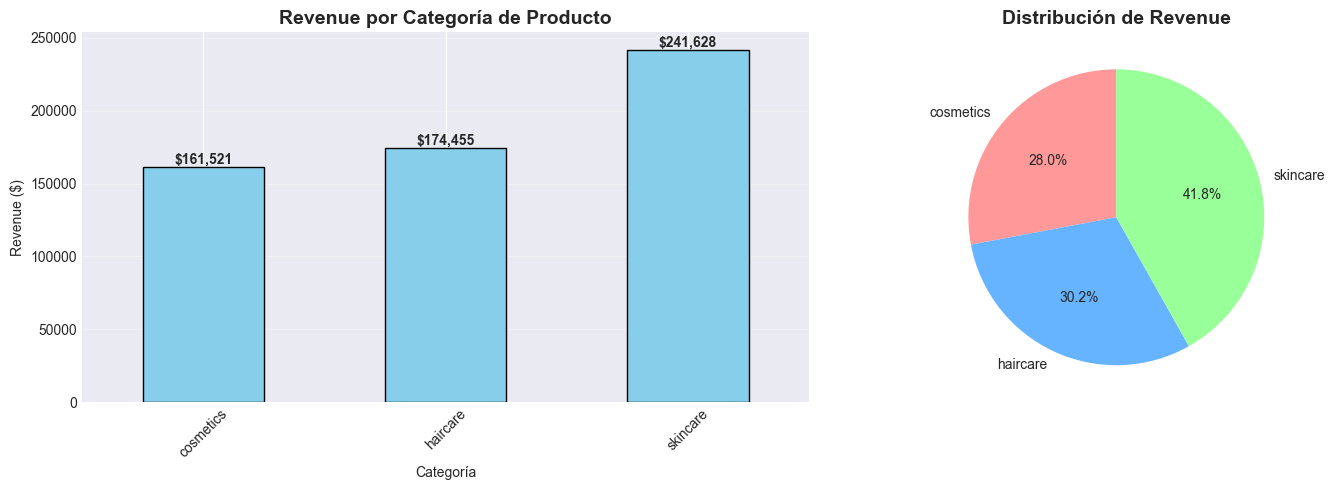

💡 Insight: El análisis muestra la distribución del revenue entre categorías.


In [9]:
# Gráfico de Revenue por categoría
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Barras
category_analysis['Revenue Total'].plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Revenue por Categoría de Producto', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Categoría')
axes[0].set_ylabel('Revenue ($)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(category_analysis['Revenue Total']):
    axes[0].text(i, v + 100, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Pie chart
axes[1].pie(category_analysis['Revenue Total'], 
            labels=category_analysis.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=['#ff9999','#66b3ff','#99ff99'])
axes[1].set_title('Distribución de Revenue', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("💡 Insight: El análisis muestra la distribución del revenue entre categorías.")

In [10]:
print("=" * 70)
print("🚚 ANÁLISIS LOGÍSTICO")
print("=" * 70)

# Análisis por carrier
carrier_analysis = df_analysis.groupby('shipping_carrier').agg({
    'shipping_costs': ['sum', 'mean'],
    'shipping_times': 'mean',
    'sku': 'count'
}).round(2)

carrier_analysis.columns = ['Costo Total', 'Costo Promedio', 'Tiempo Promedio (días)', 'Envíos']
print("\n📦 Desempeño por Carrier:")
print(carrier_analysis.sort_values('Costo Total', ascending=False))

# Análisis por modo de transporte
transport_analysis = df_analysis.groupby('transportation_mode').agg({
    'total_costs': ['sum', 'mean'],
    'shipping_times': 'mean',
    'sku': 'count'
}).round(2)

transport_analysis.columns = ['Costo Total', 'Costo Promedio', 'Tiempo Promedio', 'Envíos']
print("\n🚛 Desempeño por Modo de Transporte:")
print(transport_analysis.sort_values('Costo Total', ascending=False))

🚚 ANÁLISIS LOGÍSTICO

📦 Desempeño por Carrier:
                  Costo Total  Costo Promedio  Tiempo Promedio (días)  Envíos
shipping_carrier                                                             
Carrier B              236.89            5.51                    5.30      43
Carrier C              162.39            5.60                    6.03      29
Carrier A              155.54            5.56                    6.14      28

🚛 Desempeño por Modo de Transporte:
                     Costo Total  Costo Promedio  Tiempo Promedio  Envíos
transportation_mode                                                      
Road                    16048.20          553.39             4.72      29
Rail                    15168.93          541.75             6.57      28
Air                     14604.51          561.71             5.12      26
Sea                      7102.93          417.82             7.12      17


🔗 ANÁLISIS DE CORRELACIONES


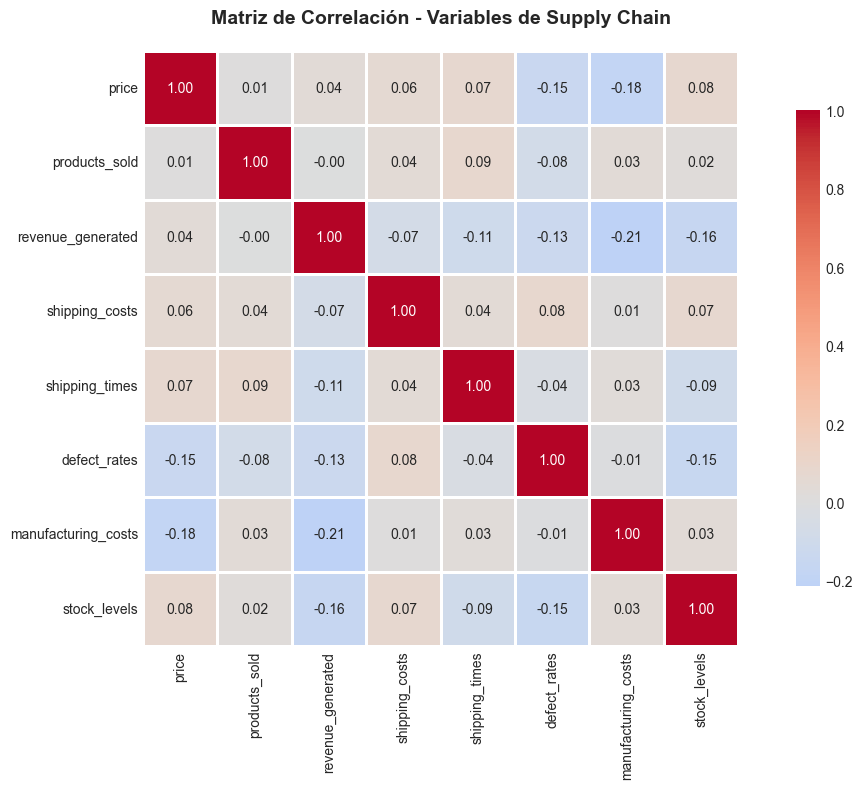


💡 INSIGHTS DE CORRELACIÓN:


In [11]:
# Matriz de correlación entre variables clave
print("=" * 70)
print("🔗 ANÁLISIS DE CORRELACIONES")
print("=" * 70)

# Seleccionar variables numéricas clave
correlation_vars = ['price', 'products_sold', 'revenue_generated', 
                    'shipping_costs', 'shipping_times', 'defect_rates',
                    'manufacturing_costs', 'stock_levels']

correlation_matrix = df_analysis[correlation_vars].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables de Supply Chain', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Insights automáticos
print("\n💡 INSIGHTS DE CORRELACIÓN:")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:  # Correlación fuerte
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            strong_correlations.append((var1, var2, corr_value))
            print(f"   • {var1} ↔ {var2}: {corr_value:.2f}")

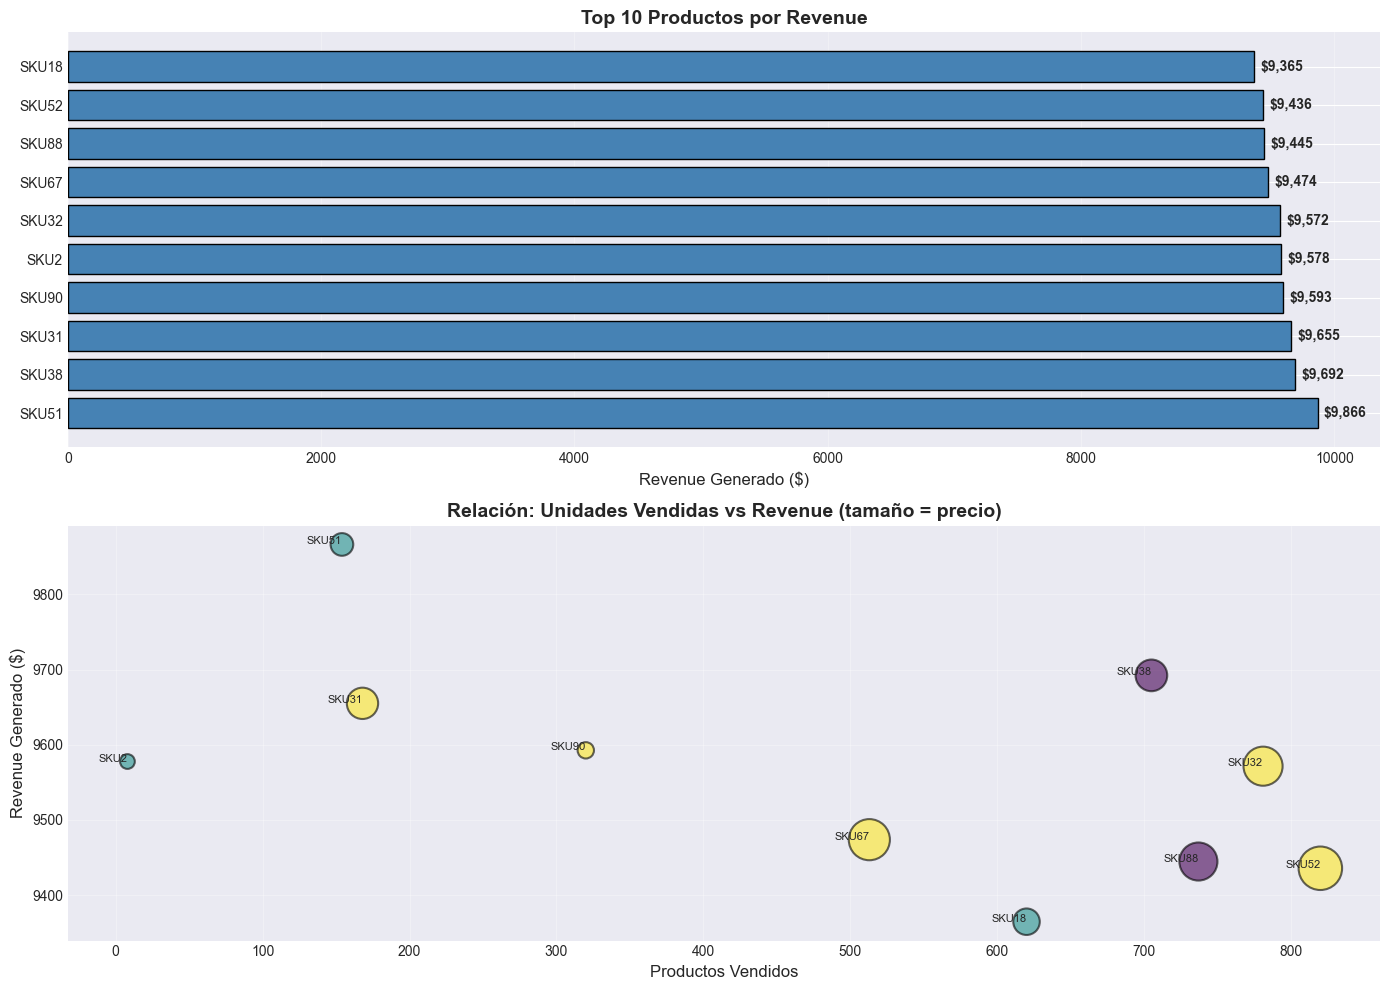


📊 TOP 10 PRODUCTOS:
  sku product_type  revenue_generated  products_sold  price
SKU51     haircare            9866.47            154  26.70
SKU38    cosmetics            9692.32            705  52.08
SKU31     skincare            9655.14            168  50.85
SKU90     skincare            9592.63            320  13.88
 SKU2     haircare            9577.75              8  11.32
SKU32     skincare            9571.55            781  79.21
SKU67     skincare            9473.80            513  87.76
SKU88    cosmetics            9444.74            737  75.27
SKU52     skincare            9435.76            820  98.03
SKU18     haircare            9364.67            620  36.44


In [12]:
# Top 10 productos por revenue
top_products = df_analysis.nlargest(10, 'revenue_generated')[
    ['sku', 'product_type', 'revenue_generated', 'products_sold', 'price']
].copy()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Revenue por SKU
axes[0].barh(top_products['sku'], top_products['revenue_generated'], 
             color='steelblue', edgecolor='black')
axes[0].set_xlabel('Revenue Generado ($)', fontsize=12)
axes[0].set_title('Top 10 Productos por Revenue', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Agregar valores
for i, (idx, row) in enumerate(top_products.iterrows()):
    axes[0].text(row['revenue_generated'] + 50, i, 
                f"${row['revenue_generated']:,.0f}", 
                va='center', fontweight='bold')

# Gráfico 2: Productos vendidos vs Revenue
scatter = axes[1].scatter(top_products['products_sold'], 
                         top_products['revenue_generated'],
                         s=top_products['price']*10,  # Tamaño proporcional al precio
                         c=top_products['product_type'].astype('category').cat.codes,
                         cmap='viridis', alpha=0.6, edgecolors='black', linewidth=1.5)

axes[1].set_xlabel('Productos Vendidos', fontsize=12)
axes[1].set_ylabel('Revenue Generado ($)', fontsize=12)
axes[1].set_title('Relación: Unidades Vendidas vs Revenue (tamaño = precio)', 
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Agregar etiquetas
for idx, row in top_products.iterrows():
    axes[1].annotate(row['sku'], 
                    (row['products_sold'], row['revenue_generated']),
                    fontsize=8, ha='right')

plt.tight_layout()
plt.show()

print("\n📊 TOP 10 PRODUCTOS:")
print(top_products.to_string(index=False))

🚚 ANÁLISIS DE EFICIENCIA LOGÍSTICA


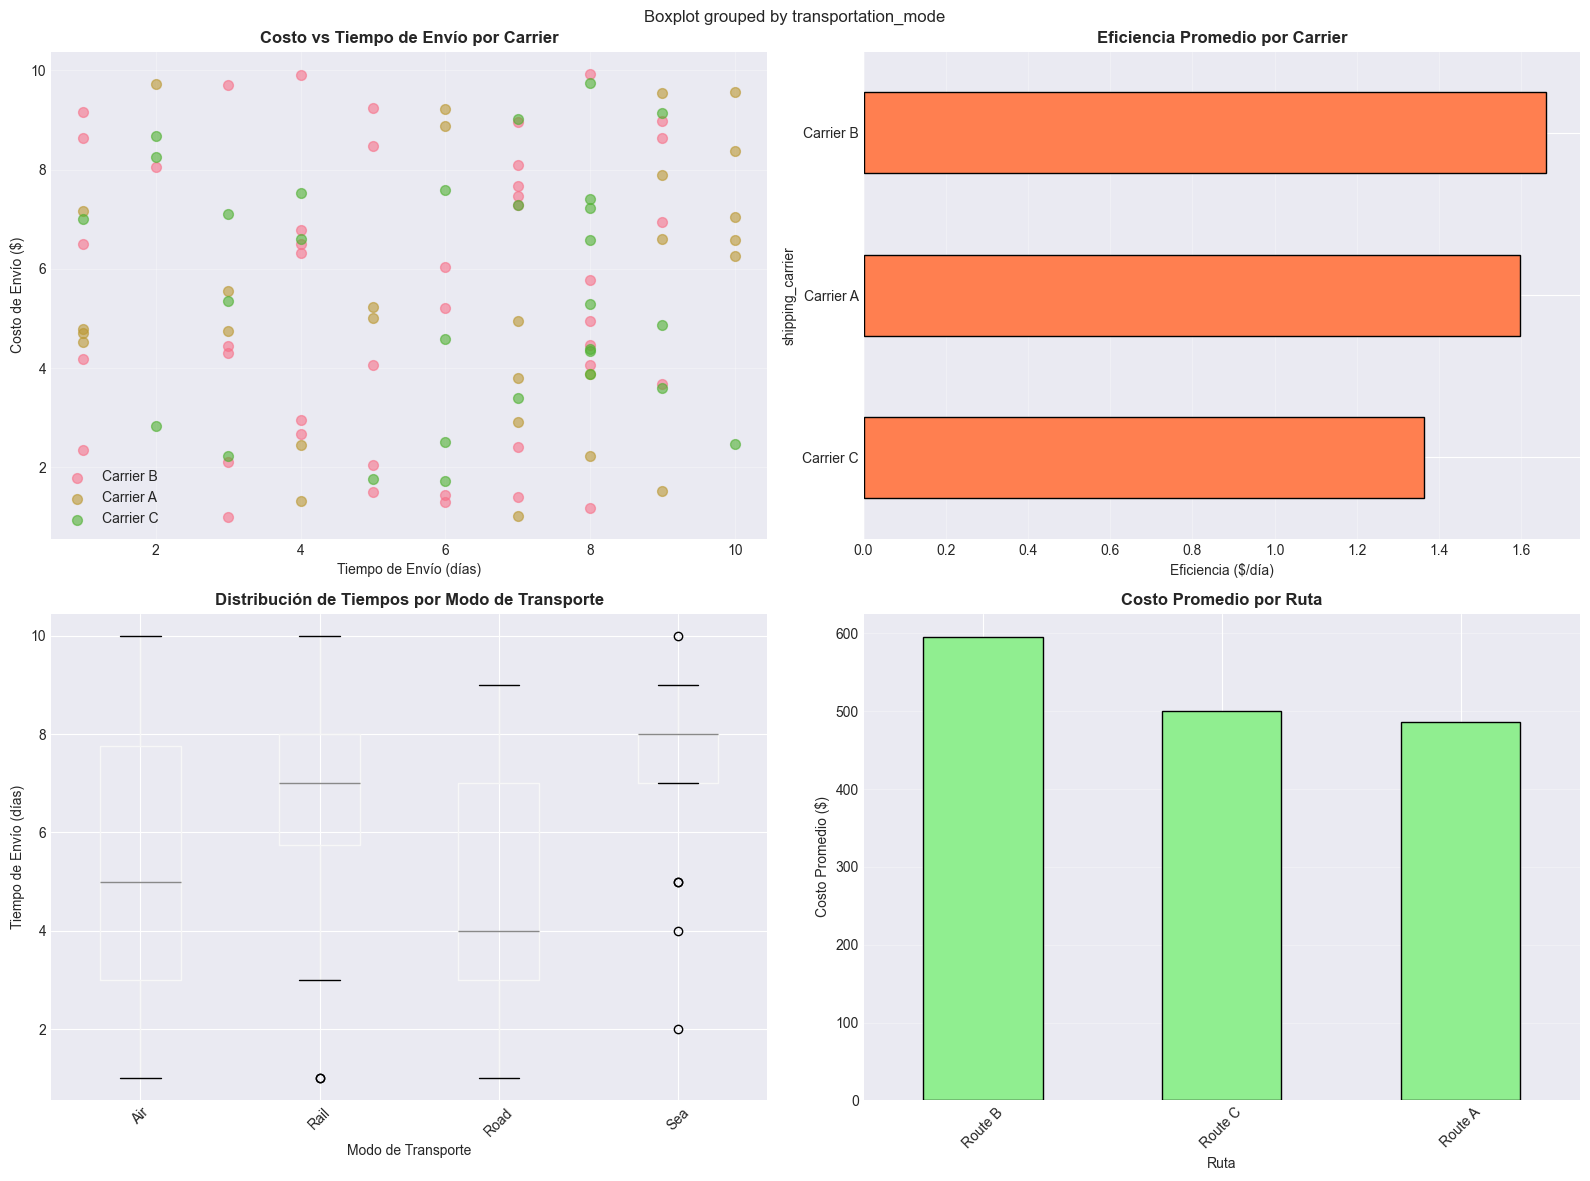


💡 INSIGHTS:
   ✅ Carrier más eficiente: Carrier C ($1.36/día)
   ❌ Carrier menos eficiente: Carrier B ($1.66/día)


In [13]:
# Análisis de eficiencia: Costo de shipping vs tiempo
print("=" * 70)
print("🚚 ANÁLISIS DE EFICIENCIA LOGÍSTICA")
print("=" * 70)

# Calcular eficiencia (menor costo y menor tiempo = más eficiente)
df_analysis['shipping_efficiency'] = (
    df_analysis['shipping_costs'] / df_analysis['shipping_times']
)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Shipping cost vs Shipping time
for carrier in df_analysis['shipping_carrier'].unique():
    carrier_data = df_analysis[df_analysis['shipping_carrier'] == carrier]
    axes[0, 0].scatter(carrier_data['shipping_times'], 
                      carrier_data['shipping_costs'],
                      label=carrier, alpha=0.6, s=50)

axes[0, 0].set_xlabel('Tiempo de Envío (días)')
axes[0, 0].set_ylabel('Costo de Envío ($)')
axes[0, 0].set_title('Costo vs Tiempo de Envío por Carrier', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Eficiencia por carrier
efficiency_by_carrier = df_analysis.groupby('shipping_carrier')['shipping_efficiency'].mean().sort_values()
efficiency_by_carrier.plot(kind='barh', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Eficiencia ($/día)')
axes[0, 1].set_title('Eficiencia Promedio por Carrier', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Gráfico 3: Distribución de tiempos de envío
df_analysis.boxplot(column='shipping_times', by='transportation_mode', ax=axes[1, 0])
axes[1, 0].set_xlabel('Modo de Transporte')
axes[1, 0].set_ylabel('Tiempo de Envío (días)')
axes[1, 0].set_title('Distribución de Tiempos por Modo de Transporte', fontweight='bold')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# Gráfico 4: Costos por ruta
route_costs = df_analysis.groupby('route')['total_costs'].mean().sort_values(ascending=False)
route_costs.plot(kind='bar', ax=axes[1, 1], color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Ruta')
axes[1, 1].set_ylabel('Costo Promedio ($)')
axes[1, 1].set_title('Costo Promedio por Ruta', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Mejor y peor carrier
best_carrier = efficiency_by_carrier.index[0]
worst_carrier = efficiency_by_carrier.index[-1]

print(f"\n💡 INSIGHTS:")
print(f"   ✅ Carrier más eficiente: {best_carrier} (${efficiency_by_carrier[best_carrier]:.2f}/día)")
print(f"   ❌ Carrier menos eficiente: {worst_carrier} (${efficiency_by_carrier[worst_carrier]:.2f}/día)")

⚠️  ANÁLISIS DE CALIDAD Y DEFECTOS


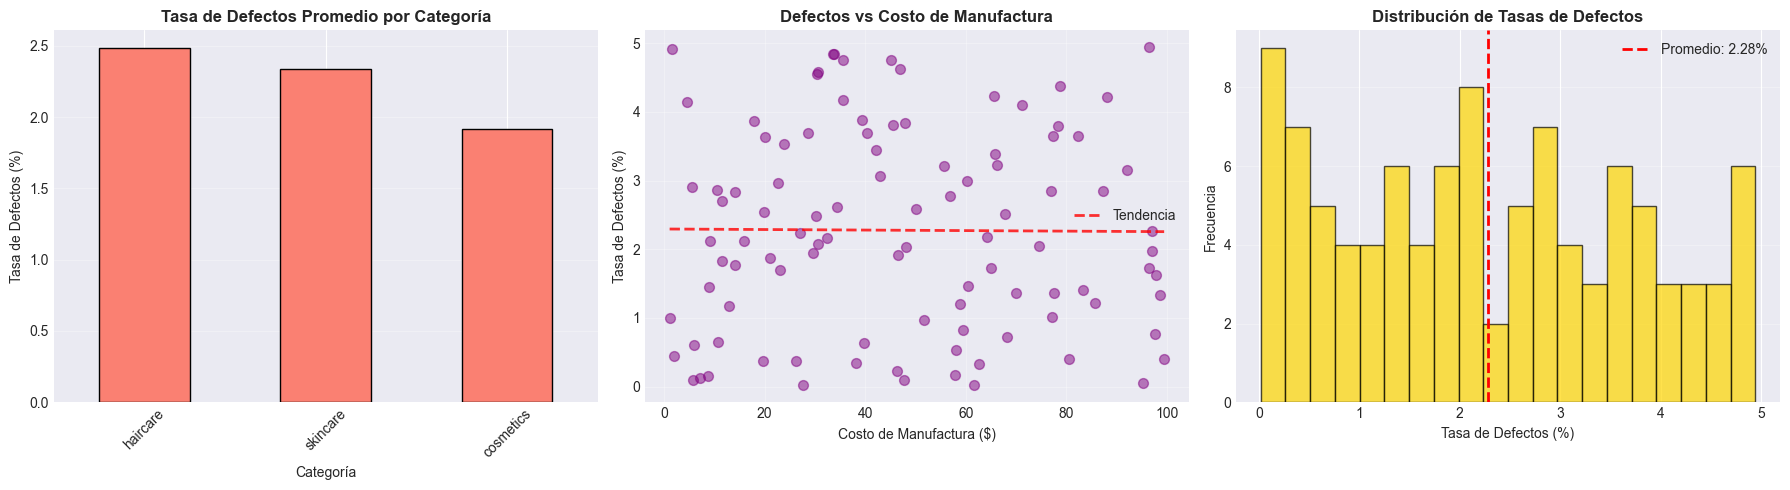


🚨 TOP 5 PRODUCTOS CON MAYOR TASA DE DEFECTOS:
  sku product_type  defect_rates inspection_results
SKU42     skincare          4.94               Fail
SKU65     skincare          4.91               Fail
 SKU1     skincare          4.85            Pending
SKU84     haircare          4.84               Pass
 SKU3     skincare          4.75               Fail


In [14]:
# Análisis de tasa de defectos
print("=" * 70)
print("⚠️  ANÁLISIS DE CALIDAD Y DEFECTOS")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Tasa de defectos por categoría
defects_by_category = df_analysis.groupby('product_type')['defect_rates'].mean().sort_values(ascending=False)
defects_by_category.plot(kind='bar', ax=axes[0], color='salmon', edgecolor='black')
axes[0].set_title('Tasa de Defectos Promedio por Categoría', fontweight='bold')
axes[0].set_ylabel('Tasa de Defectos (%)')
axes[0].set_xlabel('Categoría')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Relación defectos vs costo de manufactura
axes[1].scatter(df_analysis['manufacturing_costs'], 
               df_analysis['defect_rates'],
               alpha=0.5, c='purple', s=50)
axes[1].set_xlabel('Costo de Manufactura ($)')
axes[1].set_ylabel('Tasa de Defectos (%)')
axes[1].set_title('Defectos vs Costo de Manufactura', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Calcular línea de tendencia
z = np.polyfit(df_analysis['manufacturing_costs'], df_analysis['defect_rates'], 1)
p = np.poly1d(z)
axes[1].plot(df_analysis['manufacturing_costs'].sort_values(), 
            p(df_analysis['manufacturing_costs'].sort_values()),
            "r--", alpha=0.8, linewidth=2, label='Tendencia')
axes[1].legend()

# Gráfico 3: Histograma de tasas de defectos
axes[2].hist(df_analysis['defect_rates'], bins=20, color='gold', edgecolor='black', alpha=0.7)
axes[2].axvline(df_analysis['defect_rates'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f'Promedio: {df_analysis["defect_rates"].mean():.2f}%')
axes[2].set_xlabel('Tasa de Defectos (%)')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Distribución de Tasas de Defectos', fontweight='bold')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Productos con mayor tasa de defectos
high_defects = df_analysis.nlargest(5, 'defect_rates')[['sku', 'product_type', 'defect_rates', 'inspection_results']]
print("\n🚨 TOP 5 PRODUCTOS CON MAYOR TASA DE DEFECTOS:")
print(high_defects.to_string(index=False))

In [15]:
print("=" * 80)
print("📊 RESUMEN EJECUTIVO - ANÁLISIS DE SUPPLY CHAIN")
print("=" * 80)

# KPIs consolidados
print("\n💰 FINANCIERO:")
print(f"   • Revenue Total: ${df_analysis['revenue_generated'].sum():,.2f}")
print(f"   • Costo Logístico Total: ${df_analysis['shipping_costs'].sum():,.2f}")
print(f"   • Costo de Manufactura Total: ${df_analysis['manufacturing_costs'].sum():,.2f}")

total_costs = df_analysis['shipping_costs'].sum() + df_analysis['manufacturing_costs'].sum()
net_margin = ((df_analysis['revenue_generated'].sum() - total_costs) / df_analysis['revenue_generated'].sum()) * 100
print(f"   • Margen Neto (Revenue - Costos): {net_margin:.2f}%")

print("\n📦 OPERACIONAL:")
print(f"   • Total Productos Vendidos: {df_analysis['products_sold'].sum():,} unidades")
print(f"   • SKUs Únicos: {df_analysis['sku'].nunique()}")
print(f"   • Stock Promedio: {df_analysis['stock_levels'].mean():.0f} unidades")
print(f"   • Tiempo de Entrega Promedio: {df_analysis['shipping_times'].mean():.1f} días")

print("\n⚠️  CALIDAD:")
print(f"   • Tasa de Defectos Promedio: {df_analysis['defect_rates'].mean():.2f}%")
print(f"   • Productos con Defectos >3%: {len(df_analysis[df_analysis['defect_rates'] > 3])}")

print("\n" + "=" * 80)
print("💡 INSIGHTS Y RECOMENDACIONES ACCIONABLES")
print("=" * 80)

# 1. Mejor y peor categoría
best_category = df_analysis.groupby('product_type')['revenue_generated'].sum().idxmax()
worst_category = df_analysis.groupby('product_type')['revenue_generated'].sum().idxmin()

print(f"\n1️⃣  GESTIÓN DE PORTAFOLIO:")
print(f"   ✅ Categoría líder: {best_category}")
print(f"      → ACCIÓN: Aumentar inventario y promociones en esta categoría")
print(f"   ⚠️  Categoría de bajo rendimiento: {worst_category}")
print(f"      → ACCIÓN: Revisar pricing o considerar discontinuar productos de baja rotación")

# 2. Eficiencia logística
df_analysis['cost_per_day'] = df_analysis['shipping_costs'] / df_analysis['shipping_times']
best_carrier = df_analysis.groupby('shipping_carrier')['cost_per_day'].mean().idxmin()
worst_carrier = df_analysis.groupby('shipping_carrier')['cost_per_day'].mean().idxmax()

print(f"\n2️⃣  OPTIMIZACIÓN LOGÍSTICA:")
print(f"   ✅ Carrier más eficiente: {best_carrier}")
print(f"      → ACCIÓN: Negociar mejores tarifas con este carrier y aumentar volumen")
print(f"   ❌ Carrier menos eficiente: {worst_carrier}")
print(f"      → ACCIÓN: Renegociar contratos o buscar alternativas")

# 3. Calidad
high_defect_products = df_analysis[df_analysis['defect_rates'] > df_analysis['defect_rates'].quantile(0.75)]
print(f"\n3️⃣  MEJORA DE CALIDAD:")
print(f"   ⚠️  {len(high_defect_products)} productos con tasa de defectos alta")
print(f"      → ACCIÓN: Auditar procesos de manufactura de estos SKUs")
print(f"      → ACCIÓN: Implementar controles de calidad adicionales")

# 4. Inventario
high_stock_low_sales = df_analysis[
    (df_analysis['stock_levels'] > df_analysis['stock_levels'].quantile(0.75)) &
    (df_analysis['products_sold'] < df_analysis['products_sold'].quantile(0.25))
]
print(f"\n4️⃣  GESTIÓN DE INVENTARIO:")
print(f"   📦 {len(high_stock_low_sales)} productos con alto stock pero bajas ventas")
print(f"      → ACCIÓN: Implementar promociones para liquidar inventario")
print(f"      → ACCIÓN: Ajustar pronósticos de demanda y políticas de reorden")

# 5. Revenue por categoría
revenue_by_category = df_analysis.groupby('product_type')['revenue_generated'].sum()
top_revenue_pct = (revenue_by_category.max() / revenue_by_category.sum()) * 100

print(f"\n5️⃣  DIVERSIFICACIÓN:")
print(f"   📊 La categoría líder representa {top_revenue_pct:.1f}% del revenue total")
if top_revenue_pct > 50:
    print(f"      ⚠️  RIESGO: Alta dependencia en una categoría")
    print(f"      → ACCIÓN: Diversificar portafolio para mitigar riesgo")
else:
    print(f"      ✅ Portafolio balanceado")

print("\n" + "=" * 80)
print("🎯 PRIORIDADES INMEDIATAS (próximos 30 días)")
print("=" * 80)
print("\n1. Renegociar contrato con carrier menos eficiente")
print("2. Auditar calidad de productos con tasa de defectos >3%")
print("3. Implementar campaña de liquidación para productos con alto stock/bajas ventas")
print("4. Analizar estrategia de pricing en categoría de bajo rendimiento")
print("5. Reunión con proveedor líder para asegurar capacidad ante aumento de demanda")

print("\n" + "=" * 80)

📊 RESUMEN EJECUTIVO - ANÁLISIS DE SUPPLY CHAIN

💰 FINANCIERO:
   • Revenue Total: $577,604.86
   • Costo Logístico Total: $554.82
   • Costo de Manufactura Total: $4,726.64
   • Margen Neto (Revenue - Costos): 99.09%

📦 OPERACIONAL:
   • Total Productos Vendidos: 46,099 unidades
   • SKUs Únicos: 100
   • Stock Promedio: 48 unidades
   • Tiempo de Entrega Promedio: 5.8 días

⚠️  CALIDAD:
   • Tasa de Defectos Promedio: 2.28%
   • Productos con Defectos >3%: 32

💡 INSIGHTS Y RECOMENDACIONES ACCIONABLES

1️⃣  GESTIÓN DE PORTAFOLIO:
   ✅ Categoría líder: skincare
      → ACCIÓN: Aumentar inventario y promociones en esta categoría
   ⚠️  Categoría de bajo rendimiento: cosmetics
      → ACCIÓN: Revisar pricing o considerar discontinuar productos de baja rotación

2️⃣  OPTIMIZACIÓN LOGÍSTICA:
   ✅ Carrier más eficiente: Carrier C
      → ACCIÓN: Negociar mejores tarifas con este carrier y aumentar volumen
   ❌ Carrier menos eficiente: Carrier B
      → ACCIÓN: Renegociar contratos o buscar a

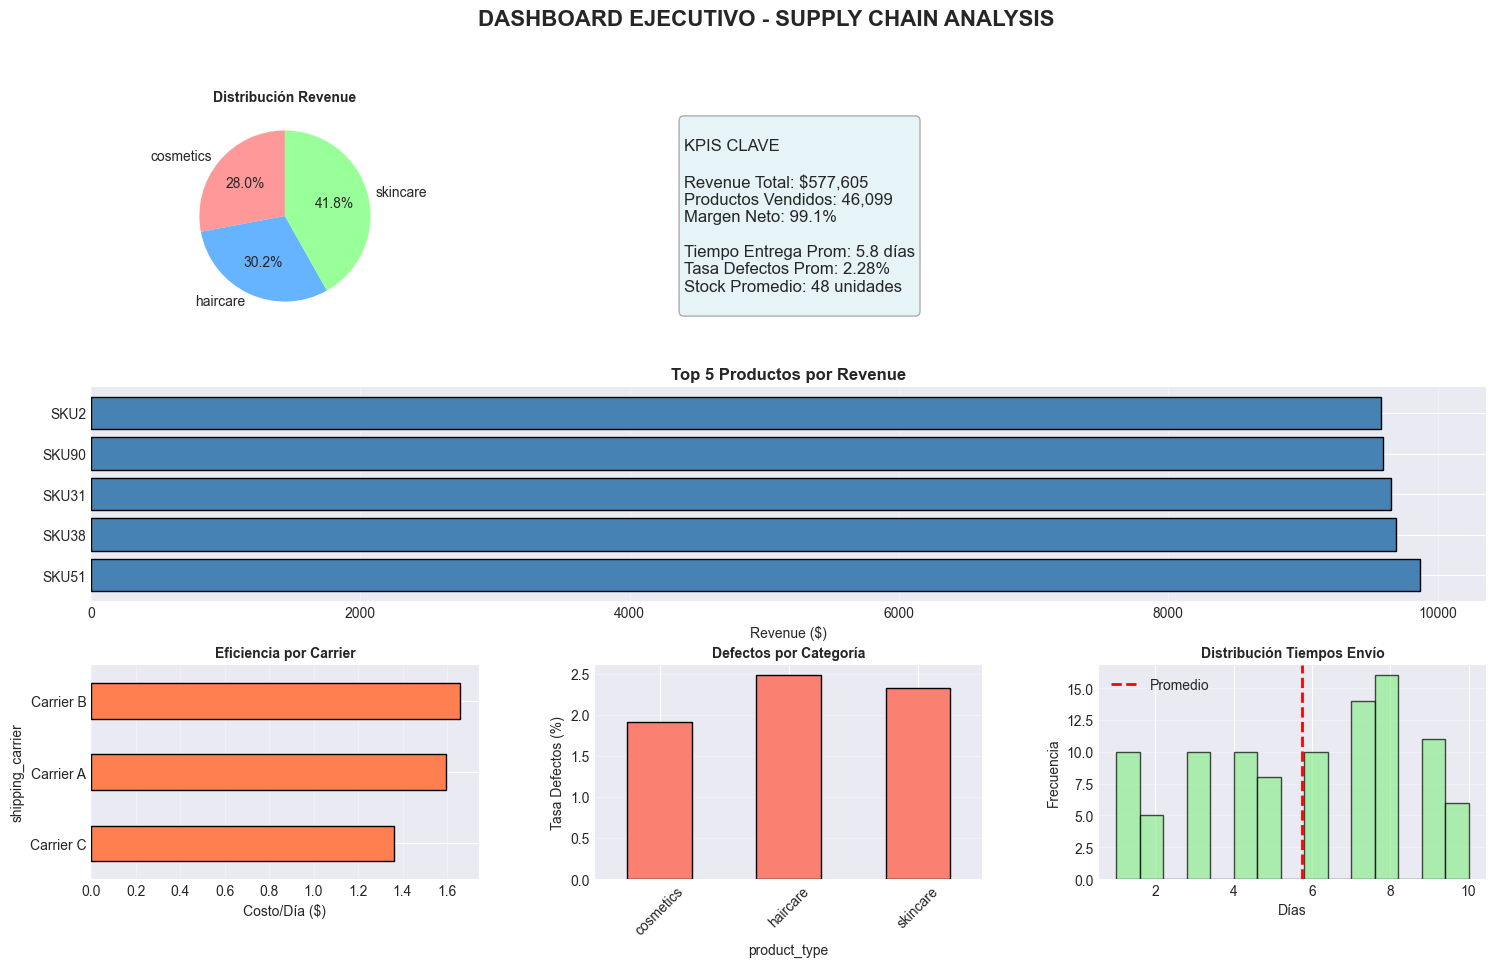


✅ Dashboard ejecutivo generado
📊 Este dashboard puede ser exportado y presentado a stakeholders


In [16]:
# Dashboard consolidado final
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Revenue por categoría (Pie)
ax1 = fig.add_subplot(gs[0, 0])
revenue_by_cat = df_analysis.groupby('product_type')['revenue_generated'].sum()
ax1.pie(revenue_by_cat, labels=revenue_by_cat.index, autopct='%1.1f%%', 
        colors=['#ff9999','#66b3ff','#99ff99'], startangle=90)
ax1.set_title('Distribución Revenue', fontweight='bold', fontsize=10)

# 2. KPI Cards simulados
ax2 = fig.add_subplot(gs[0, 1:])
ax2.axis('off')
kpi_text = f"""
KPIS CLAVE

Revenue Total: ${df_analysis['revenue_generated'].sum():,.0f}
Productos Vendidos: {df_analysis['products_sold'].sum():,}
Margen Neto: {net_margin:.1f}%

Tiempo Entrega Prom: {df_analysis['shipping_times'].mean():.1f} días
Tasa Defectos Prom: {df_analysis['defect_rates'].mean():.2f}%
Stock Promedio: {df_analysis['stock_levels'].mean():.0f} unidades
"""
ax2.text(0.1, 0.5, kpi_text, fontsize=12, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 3. Top 5 productos por revenue
ax3 = fig.add_subplot(gs[1, :])
top5 = df_analysis.nlargest(5, 'revenue_generated')
ax3.barh(top5['sku'], top5['revenue_generated'], color='steelblue', edgecolor='black')
ax3.set_xlabel('Revenue ($)')
ax3.set_title('Top 5 Productos por Revenue', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Eficiencia por carrier
ax4 = fig.add_subplot(gs[2, 0])
carrier_eff = df_analysis.groupby('shipping_carrier')['cost_per_day'].mean().sort_values()
carrier_eff.plot(kind='barh', ax=ax4, color='coral', edgecolor='black')
ax4.set_xlabel('Costo/Día ($)')
ax4.set_title('Eficiencia por Carrier', fontweight='bold', fontsize=10)
ax4.grid(axis='x', alpha=0.3)

# 5. Defectos por categoría
ax5 = fig.add_subplot(gs[2, 1])
defects = df_analysis.groupby('product_type')['defect_rates'].mean()
defects.plot(kind='bar', ax=ax5, color='salmon', edgecolor='black')
ax5.set_ylabel('Tasa Defectos (%)')
ax5.set_title('Defectos por Categoría', fontweight='bold', fontsize=10)
ax5.tick_params(axis='x', rotation=45)
ax5.grid(axis='y', alpha=0.3)

# 6. Distribución de tiempos de envío
ax6 = fig.add_subplot(gs[2, 2])
ax6.hist(df_analysis['shipping_times'], bins=15, color='lightgreen', 
         edgecolor='black', alpha=0.7)
ax6.axvline(df_analysis['shipping_times'].mean(), color='red', 
           linestyle='--', linewidth=2, label='Promedio')
ax6.set_xlabel('Días')
ax6.set_ylabel('Frecuencia')
ax6.set_title('Distribución Tiempos Envío', fontweight='bold', fontsize=10)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.suptitle('DASHBOARD EJECUTIVO - SUPPLY CHAIN ANALYSIS', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\n✅ Dashboard ejecutivo generado")
print("📊 Este dashboard puede ser exportado y presentado a stakeholders")

In [17]:
# Exportar insights a CSV para futuras referencias
output_path = os.path.join('..', 'outputs')

# Top productos
top_products_export = df_analysis.nlargest(20, 'revenue_generated')[
    ['sku', 'product_type', 'revenue_generated', 'products_sold', 
     'price', 'defect_rates', 'shipping_costs']
]
top_products_export.to_csv(f'{output_path}/top_productos.csv', index=False)

# Resumen por categoría
category_summary = df_analysis.groupby('product_type').agg({
    'revenue_generated': 'sum',
    'products_sold': 'sum',
    'shipping_costs': 'sum',
    'defect_rates': 'mean',
    'stock_levels': 'mean'
}).round(2)
category_summary.to_csv(f'{output_path}/resumen_categorias.csv')

# Productos con alertas (alto stock, bajas ventas, alta tasa defectos)
alerts = df_analysis[
    (df_analysis['stock_levels'] > df_analysis['stock_levels'].quantile(0.75)) |
    (df_analysis['defect_rates'] > 3) |
    (df_analysis['products_sold'] < df_analysis['products_sold'].quantile(0.25))
][['sku', 'product_type', 'stock_levels', 'products_sold', 'defect_rates']]
alerts.to_csv(f'{output_path}/productos_alerta.csv', index=False)

print("✅ Archivos exportados:")
print(f"   📄 {output_path}/top_productos.csv")
print(f"   📄 {output_path}/resumen_categorias.csv")
print(f"   📄 {output_path}/productos_alerta.csv")
print("\n🎉 ANÁLISIS COMPLETADO")

✅ Archivos exportados:
   📄 ..\outputs/top_productos.csv
   📄 ..\outputs/resumen_categorias.csv
   📄 ..\outputs/productos_alerta.csv

🎉 ANÁLISIS COMPLETADO
